### Getting the most recent EPL player stats from fbref.com

reference: https://chmartin.github.io/2019/02/18/EPL-History-Scraping.html

In [1]:
# who performs well against lower performing teams? - punt
# who is "fixture proof" - long term keeper
# focus on individual player stats (goals and assists) rather than team stats

# Import the libraries we need
import pandas as pd
import re
import random
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
import datetime

In [2]:
# set url for understat
plyrs_xg_url = 'https://fbref.com/en/comps/9/stats/Premier-League-Stats'

# download the webpage
plyrs_xg_data = requests.get(plyrs_xg_url)

comm = re.compile("<!--|-->")
soup = BeautifulSoup(comm.sub("",plyrs_xg_data.text),'lxml')

print(soup.title)

<title>Premier League Player Stats | FBref.com</title>


In [3]:
#find the tables within the html
all_tables = soup.findAll("tbody")

#there are team and player tables. Set the 3rd table as player_table
#team_table = all_tables[0]
player_table = all_tables[2]

#len(all_tables)
#print(player_table)

In [4]:
pre_df_plyrs = dict()
    #Note: features does not contain squad name, it requires special treatment
features_wanted_plyrs = {"player","position", "squad", "games", "games_starts", "minutes","goals","assists", 
                         "goals_pens","pens_made", "pens_att", "goals_per90","assists_per90",
                         "goals_assists_per90","goals_pens_per90","goals_assists_pens_per90","xg","npxg","xa",
                         "npxg_xa","xg_per90","xa_per90","xg_xa_per90","npxg_per90","npxg_xa_per90"}

rows_plyrs = player_table.find_all('tr')
for row in rows_plyrs:
    if(row.find('th',{"scope":"row"}) != None):
        name = row.find('th',{"data-stat":"ranker"}).text.strip().encode().decode("utf-8")
        if 'ranker' in pre_df_plyrs:
            pre_df_plyrs['ranker'].append(name)
        else:
            pre_df_plyrs['ranker'] = [name]
        for f in features_wanted_plyrs:
            cell = row.find("td",{"data-stat": f})
            a = cell.text.strip().encode()
            text=a.decode("utf-8")
            if f in pre_df_plyrs:
                pre_df_plyrs[f].append(text)
            else:
                pre_df_plyrs[f] = [text]

In [5]:
df_plyrs = pd.DataFrame.from_dict(pre_df_plyrs)

df_plyrs.head()
#print(df_plyrs)
#df_plyrs.to_csv(output_name)

,ranker,position,goals_per90,assists_per90,xg_xa_per90,pens_att,goals_assists_per90,npxg,goals_pens_per90,minutes,...,games,goals_pens,npxg_per90,npxg_xa_per90,xg_per90,pens_made,xa_per90,npxg_xa,goals_assists_pens_per90,player
0,1,DF,0.00,0.00,0.10,0,0.00,0.2,0.00,810,...,9,0,0.02,0.10,0.02,0,0.08,0.9,0.00,Max Aarons
1,2,"FW,MF",0.00,0.23,0.38,0,0.23,0.6,0.00,392,...,6,0,0.14,0.38,0.14,0,0.24,1.7,0.23,Che Adams
2,3,"DF,FW",0.00,0.00,0.16,0,0.00,0.2,0.00,89,...,2,0,0.16,0.16,0.16,0,0.00,0.2,0.00,Rayan Aït Nouri
3,4,DF,0.00,0.00,0.07,0,0.00,0.2,0.00,565,...,7,0,0.03,0.07,0.03,0,0.05,0.5,0.00,Kristoffer Ajer
4,5,DF,0.00,0.00,0.07,0,0.00,0.2,0.00,270,...,3,0,0.07,0.07,0.07,0,0.00,0.2,0.00,Nathan Aké


### Getting the most recent player prices from the FPL website

reference: https://towardsdatascience.com/fantasy-premier-league-value-analysis-python-tutorial-using-the-fpl-api-8031edfe9910

In [6]:
# get the player prices from https://fantasy.premierleague.com/statistics and combine with player stat table above
# set url for fantasy PL API
api_url = "https://fantasy.premierleague.com/api/bootstrap-static/"

# download the webpage
r = requests.get(api_url)

json = r.json()

json.keys()

dict_keys(['events', 'game_settings', 'phases', 'teams', 'total_players', 'elements', 'element_stats', 'element_types'])

In [7]:
# build a dataframe
elements_df = pd.DataFrame(json['elements'])

elements_df.columns

Index(['chance_of_playing_next_round', 'chance_of_playing_this_round', 'code',
       'cost_change_event', 'cost_change_event_fall', 'cost_change_start',
       'cost_change_start_fall', 'dreamteam_count', 'element_type', 'ep_next',
       'ep_this', 'event_points', 'first_name', 'form', 'id', 'in_dreamteam',
       'news', 'news_added', 'now_cost', 'photo', 'points_per_game',
       'second_name', 'selected_by_percent', 'special', 'squad_number',
       'status', 'team', 'team_code', 'total_points', 'transfers_in',
       'transfers_in_event', 'transfers_out', 'transfers_out_event',
       'value_form', 'value_season', 'web_name', 'minutes', 'goals_scored',
       'assists', 'clean_sheets', 'goals_conceded', 'own_goals',
       'penalties_saved', 'penalties_missed', 'yellow_cards', 'red_cards',
       'saves', 'bonus', 'bps', 'influence', 'creativity', 'threat',
       'ict_index', 'influence_rank', 'influence_rank_type', 'creativity_rank',
       'creativity_rank_type', 'threat_rank'

In [8]:
#select only relevant columns from elements_df
elements_df_select = elements_df[['first_name','second_name','team','element_type','selected_by_percent',
                                'now_cost','minutes','transfers_in','value_season','total_points']]

# combine first and last names to get player full names
elements_df_select['full_name'] = elements_df_select[['first_name', 'second_name']].agg(' '.join, axis=1)

# player prices are 10x the true value. Divide the prices by 10 to get the true values
elements_df_select['now_cost'] = elements_df_select['now_cost']/10

elements_df_select.head()

<ipython-input-8-c7a7c3dc5be8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  elements_df_select['full_name'] = elements_df_select[['first_name', 'second_name']].agg(' '.join, axis=1)
<ipython-input-8-c7a7c3dc5be8>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  elements_df_select['now_cost'] = elements_df_select['now_cost']/10


,first_name,second_name,team,element_type,selected_by_percent,now_cost,minutes,transfers_in,value_season,total_points,full_name
0,Bernd,Leno,1,1,1.1,4.7,270,57046,0.9,4,Bernd Leno
1,Rúnar Alex,Rúnarsson,1,1,0.8,4.0,0,19017,0.0,0,Rúnar Alex Rúnarsson
2,Willian,Borges Da Silva,1,3,0.1,6.3,0,914,0.0,0,Willian Borges Da Silva
3,Pierre-Emerick,Aubameyang,1,4,5.0,10.0,698,503720,3.9,39,Pierre-Emerick Aubameyang
4,Cédric,Soares,1,2,0.2,4.2,188,10553,0.2,1,Cédric Soares


### Combine the player stats table with the player prices

In [9]:
# set the new dataframe
prices = elements_df_select[['full_name', 'now_cost']]
prices_stats_df = pd.merge(df_plyrs, prices, left_on = 'player', right_on = 'full_name')

# find a specific player to confirm values are accurate
# note prices are missing the decimal place and are shown as 10x the true value
# prices_stats_df.loc[prices_stats_df['full_name']=='Mohamed Salah']

prices_stats_df.head()

,ranker,position,goals_per90,assists_per90,xg_xa_per90,pens_att,goals_assists_per90,npxg,goals_pens_per90,minutes,...,npxg_per90,npxg_xa_per90,xg_per90,pens_made,xa_per90,npxg_xa,goals_assists_pens_per90,player,full_name,now_cost
0,1,DF,0.00,0.00,0.10,0,0.00,0.2,0.00,810,...,0.02,0.10,0.02,0,0.08,0.9,0.00,Max Aarons,Max Aarons,4.4
1,2,"FW,MF",0.00,0.23,0.38,0,0.23,0.6,0.00,392,...,0.14,0.38,0.14,0,0.24,1.7,0.23,Che Adams,Che Adams,6.8
2,4,DF,0.00,0.00,0.07,0,0.00,0.2,0.00,565,...,0.03,0.07,0.03,0,0.05,0.5,0.00,Kristoffer Ajer,Kristoffer Ajer,4.5
3,5,DF,0.00,0.00,0.07,0,0.00,0.2,0.00,270,...,0.07,0.07,0.07,0,0.00,0.2,0.00,Nathan Aké,Nathan Aké,4.9
4,6,"MF,FW",0.47,0.00,0.12,0,0.47,0.0,0.47,191,...,0.02,0.12,0.02,0,0.10,0.3,0.47,Marc Albrighton,Marc Albrighton,5.3


In [18]:
# rename the now_cost column to price
prices_stats_df = prices_stats_df.rename(columns = {'now_cost':'price'})

# clean the data: convert appropriate columns to numeric values
cols = ['xg', 'xa', 'price']
prices_stats_df[cols] = prices_stats_df[cols].apply(pd.to_numeric)

# confirm the dtypes
#prices_stats_df.dtypes

prices_stats_df.head()

,ranker,position,goals_per90,assists_per90,xg_xa_per90,pens_att,goals_assists_per90,npxg,goals_pens_per90,minutes,...,npxg_per90,npxg_xa_per90,xg_per90,pens_made,xa_per90,npxg_xa,goals_assists_pens_per90,player,full_name,price
0,1,DF,0.00,0.00,0.10,0,0.00,0.2,0.00,810,...,0.02,0.10,0.02,0,0.08,0.9,0.00,Max Aarons,Max Aarons,4.4
1,2,"FW,MF",0.00,0.23,0.38,0,0.23,0.6,0.00,392,...,0.14,0.38,0.14,0,0.24,1.7,0.23,Che Adams,Che Adams,6.8
2,4,DF,0.00,0.00,0.07,0,0.00,0.2,0.00,565,...,0.03,0.07,0.03,0,0.05,0.5,0.00,Kristoffer Ajer,Kristoffer Ajer,4.5
3,5,DF,0.00,0.00,0.07,0,0.00,0.2,0.00,270,...,0.07,0.07,0.07,0,0.00,0.2,0.00,Nathan Aké,Nathan Aké,4.9
4,6,"MF,FW",0.47,0.00,0.12,0,0.47,0.0,0.47,191,...,0.02,0.12,0.02,0,0.10,0.3,0.47,Marc Albrighton,Marc Albrighton,5.3


In [11]:
# explore the data: look at top players by xg_xa_per90
xg_xa_sorted = prices_stats_df.sort_values('npxg_xa', ascending = False)

xg_xa_sorted[0:10]

,ranker,position,goals_per90,assists_per90,xg_xa_per90,pens_att,goals_assists_per90,npxg,goals_pens_per90,minutes,...,npxg_per90,npxg_xa_per90,xg_per90,pens_made,xa_per90,npxg_xa,goals_assists_pens_per90,player,full_name,price
267,339,FW,1.11,0.56,1.12,1,1.67,5.3,1.00,810,...,0.58,1.03,0.67,1,0.45,9.3,1.56,Mohamed Salah,Mohamed Salah,12.9
11,17,FW,0.76,0.38,0.94,1,1.13,4.7,0.76,715,...,0.59,0.91,0.62,0,0.32,7.2,1.13,Michail Antonio,Michail Antonio,8.2
187,236,FW,0.61,0.00,0.85,0,0.61,5.9,0.61,734,...,0.73,0.85,0.73,0,0.12,6.9,0.61,Sadio Mané,Sadio Mané,11.9
144,184,FW,0.61,0.15,0.98,0,0.76,4.2,0.61,591,...,0.63,0.98,0.63,0,0.35,6.4,0.76,Diogo Jota,Diogo Jota,7.5
314,398,FW,0.83,0.12,0.65,0,0.95,4.8,0.83,755,...,0.57,0.65,0.57,0,0.08,5.4,0.95,Jamie Vardy,Jamie Vardy,10.8
181,230,FW,0.44,0.00,0.74,0,0.44,3.1,0.44,615,...,0.46,0.74,0.46,0,0.28,5.1,0.44,Romelu Lukaku,Romelu Lukaku,11.5
196,249,FW,0.24,0.00,0.57,0,0.24,4.0,0.24,737,...,0.48,0.57,0.48,0,0.09,4.7,0.24,Bryan Mbeumo,Bryan Mbeumo,5.6
114,147,"FW,MF",0.14,0.27,0.62,0,0.41,2.0,0.14,661,...,0.27,0.62,0.27,0,0.35,4.5,0.41,Jack Grealish,Jack Grealish,7.8
304,385,FW,0.22,0.22,0.57,1,0.44,1.7,0.11,810,...,0.18,0.48,0.27,1,0.30,4.3,0.33,Ivan Toney,Ivan Toney,6.6
92,121,FW,1.22,0.31,1.28,0,1.53,3.4,1.22,294,...,1.04,1.28,1.04,0,0.23,4.2,1.53,Roberto Firmino,Roberto Firmino,8.9


### Time for some visuals

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

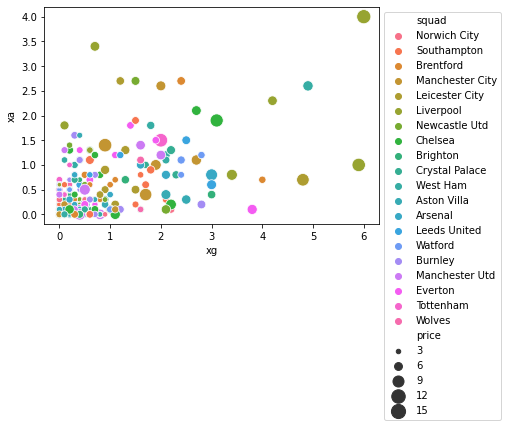

In [30]:
# create a scatter plot of xg vs. xa, with player prices as a third variable

p = sns.scatterplot(data = prices_stats_df, 
                   x = 'xg',
                   y = 'xa',
                   size = 'price',
                   sizes = (20,200),
                   hue = 'squad')

plt.legend(bbox_to_anchor = (1,1))

plt.show()

In [ ]:
# to do:
# find squad fixture list for next 3-5 matches/fixture difficulty
# find previous fixture average difficulty
# correlation of previous fixture difficulty with FPL points (goals/assists)
# find players whose performance correlates strongly with easy fixtures, or doesn't correlate